In [1]:
#Python Libraries 

import numpy as np
from matplotlib import pyplot as plt
import cv2

Convolution function

In [3]:
def conv(im, A):
    
    im_size = len(im)
    A_h, A_w = A.shape
    
    j = A_h - im_size + 1
    i = A_w - im_size + 1

    B = np.zeros((j,i))
    
    for row in range(j):
        for col in range(i):
            B[row, col] = np.sum(np.multiply(A[row:row + im_size, col: col + im_size],im))

    return B

Applying a Gaussian Blur on test images 

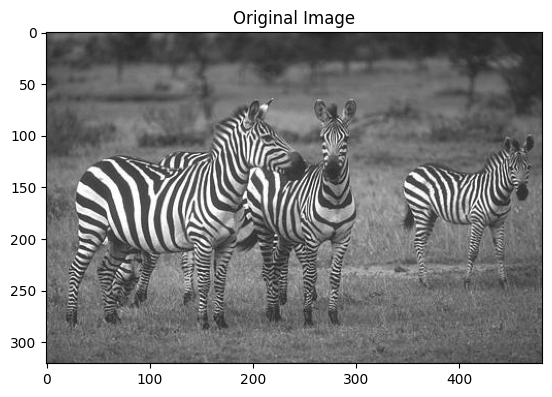

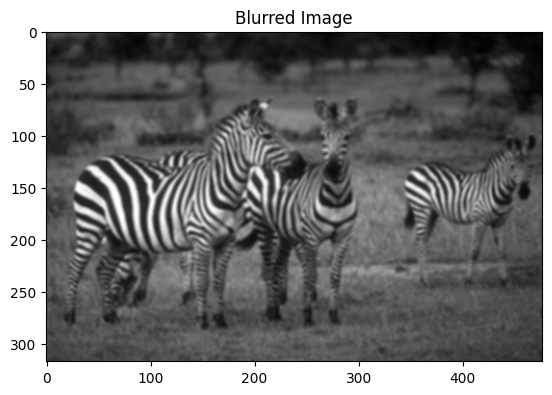

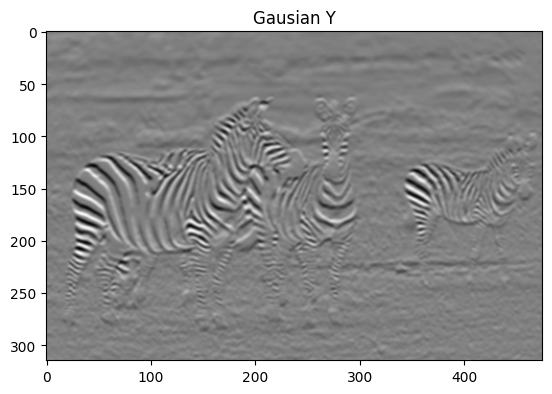

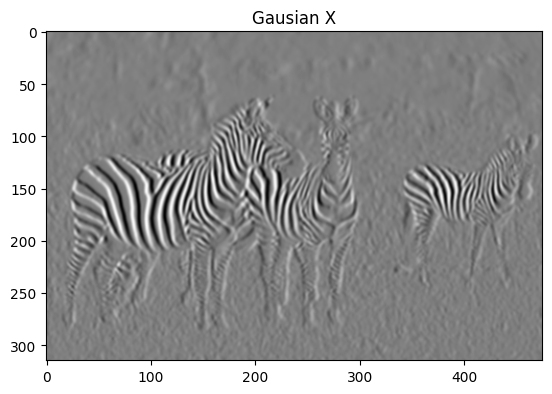

In [9]:
image = cv2.imread('data/test04.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.show()

#setting up the test kernal 
B = np.array(([2,4,5,4,2],[4,9,12,9,4],[5,12,15,12,5],[4,9,12,9,4],[2,4,5,4,2]))/159

#applying convolution
gaus = conv(B,image)
plt.imshow(gaus, cmap='gray')
plt.title('Blurred Image')
plt.show()

#Calculating the gradient with a sobel filter 
sobel_x = np.array(([-1, 0, 1],[-2, 0, 2],[-1, 0, 1]))
sobel_y = np.array(([1, 2, 1],[0, 0, 0],[-1, -2, -1]))

#calculating Gx and Gy
gaus_y = conv(sobel_y, gaus)
gaus_x = conv(sobel_x, gaus)

plt.imshow(gaus_y, cmap='gray')
plt.title('Gausian Y')
plt.show()

plt.imshow(gaus_x, cmap='gray')
plt.title('Gausian X')
plt.show()

Gradient Magnitudes 

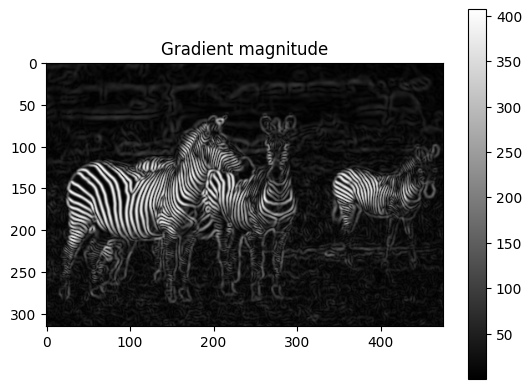

In [10]:
grad_mag = np.sqrt(np.square(gaus_y) + np.square(gaus_x))

plt.imshow(grad_mag, cmap='gray')
plt.title('Gradient magnitude')
plt.colorbar()
plt.show()
gh, gw = grad_mag.shape

Find the Gradient Orientation 

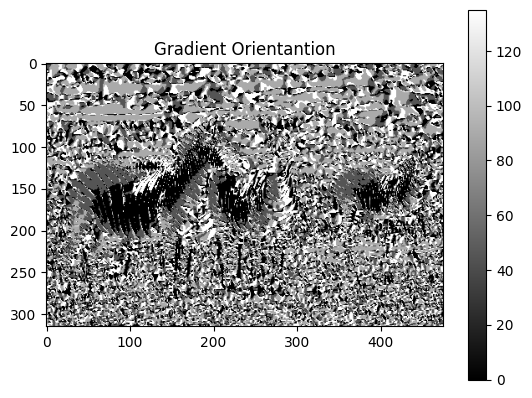

In [11]:
gh, gw = grad_mag.shape
#Setting the background to a set value (180) so there is no confusion for the 0 degrees point
orien = np.ones((gh, gw))*180
for i in range(gh):
    for j in range(gw):
        if grad_mag[i,j]!=0:
            #Steps for finding the value 
            #1) Use arctan 2 and then converting to degrees to get a value between -180 and 180
            #2) +180 to get it between 0 and 360
            #3) /45 and round it to the closes number
            #4) %4 to find a number between 0 and 4, ie 180 = 4, which will become 0
            #*45 again to find the 45 value
            orien[i,j] = (np.round((np.degrees(np.arctan2(gaus_y[i,j],gaus_x[i,j]))+180)/45)%4)*45
    
plt.imshow(orien, cmap='gray')
plt.title('Gradient Orientantion')
plt.colorbar()
plt.show()

Performing non-maximal suppression with thresholding 

95


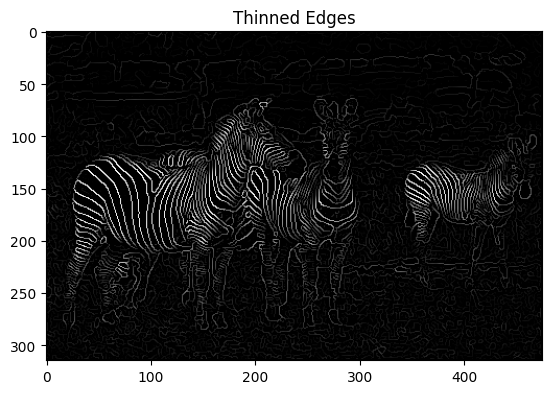

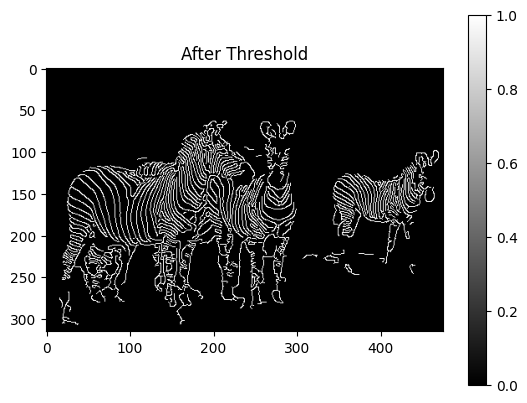

In [12]:
#shape for creating the array
o_h, o_w = orien.shape

#thinned array
thin = np.zeros((o_h,o_w))

#looping through from (1,1) to (height-1, width-1)
for i in range(1,o_h-1):
    for j in range(1,o_w-1):
        #checking each case (degrees) and checking the pixels that are in the orientation of the middle pixel
        if orien[i,j] == 0:
            if grad_mag[i, j] < grad_mag[i,j-1] or grad_mag[i, j] < grad_mag[i,j+1]:
                thin[i,j] = 0 #suppressing it if it 0
            else:
                thin[i,j] = grad_mag[i,j]#setting it the value of the Gradient magnitude array
        elif orien[i,j] == 45:
            if grad_mag[i, j] < grad_mag[i-1,j+1] or grad_mag[i, j] < grad_mag[i+1,j-1]:
                thin[i,j] = 0
            else:
                thin[i,j] = grad_mag[i,j]
        elif orien[i,j] == 90:
            if grad_mag[i, j] < grad_mag[i-1,j] or grad_mag[i, j] < grad_mag[i+1,j]:
                thin[i,j] = 0
            else:
                thin[i,j] = grad_mag[i,j]
        elif orien[i,j] == 135:
            if grad_mag[i, j] < grad_mag[i-1,j-1] or grad_mag[i, j] < grad_mag[i+1,j+1]:
                thin[i,j] = 0
            else:
                thin[i,j] = grad_mag[i,j]

# Finding the mean, std, upper and low threshold 
sigma = np.std(thin)
mean = np.mean(thin)
weak = 10
highThresh = 95
print(highThresh)
lowThresh = highThresh*0.05

#Final results array
res = np.zeros((o_h,o_w))

#For loop to check if each value is either strong, weak or suppressed
for i in range(o_h):
    for j in range(o_w):
        if thin[i,j] >= highThresh:
            res[i,j] = 1
        elif thin[i,j] > lowThresh and thin[i,j] < highThresh:
            res[i,j] = weak
        elif thin[i,j] <= lowThresh:
            res[i,j] = 0

# For loop to check if the weak pixels are surrounded by a strong pixel 
for i in range(1,o_h-1):
    for j in range(1,o_w-1):
        if res[i,j] == 10:
            if ((res[i-1,j-1] == 1) or (res[i-1,j] == 1) or (res[i-1,j+1] == 1) or (res[i,j+1] == 1) or\
            (res[i+1,j+1] == 1) or (res[i+1,j] == 1) or (res[i+1,j-1] == 1) or (res[i,j-1] == 1)):
                res[i,j] = 1
            else:
                res[i,j] = 0
        
        
plt.imshow(thin, cmap='gray')
plt.title('Thinned Edges')
plt.show()

plt.imshow(res, cmap='gray')
plt.title('After Threshold')
plt.colorbar()
plt.show()